## First draft of Contrast algorithm

## To do
- Compute standard_distances for each cluster
- When updating st_dists of cluster, project along both infinite-stdev and 0-stdev dims
- Update sensitivity -> how?
- Inverse law when seeing duplicates
- Implement context
- Compare stdevs and distances
- Clustering validity checking methods

## Imports

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
import seaborn as sns
import pandas as pd

np.random.seed(1)

## Global variables

In [2]:
NB_FEATURES = 5
NB_GROUPS = 5
N = 500
SIZE = 200
DEV = 30
colors = ['r', 'g', 'b', 'y', 'c', 'm']

## Generate dataset

In [3]:
def generate_dataset(nb_features = NB_FEATURES, nb_groups = NB_GROUPS, n = N, size=SIZE, dev=DEV):
    clusters_true = np.zeros(n)
    means = np.zeros((nb_groups, nb_features)) # holds the mean of each group
    st_devs = np.zeros((nb_groups, nb_features)) # holds the st_devs of each group
    for i in range(nb_groups):
        for j in range(nb_features):
            means[i][j] = np.random.randint(-size, size)
            st_devs[i][j] = dev*np.random.random()
    data = np.zeros((n, nb_features))
    for i in range(n):
        gi = np.random.randint(0,nb_groups)
        clusters_true[i] = gi
        for j in range(nb_features):
            data[i][j] = np.random.normal(loc = means[gi][j], scale = st_devs[gi][j])
    np.save('dummy_data.npy', data)
    np.save('dummy_clusters.npy', clusters_true)

In [4]:
generate_dataset()

data = np.load('dummy_data.npy')
clusters_true = np.load('dummy_clusters.npy')

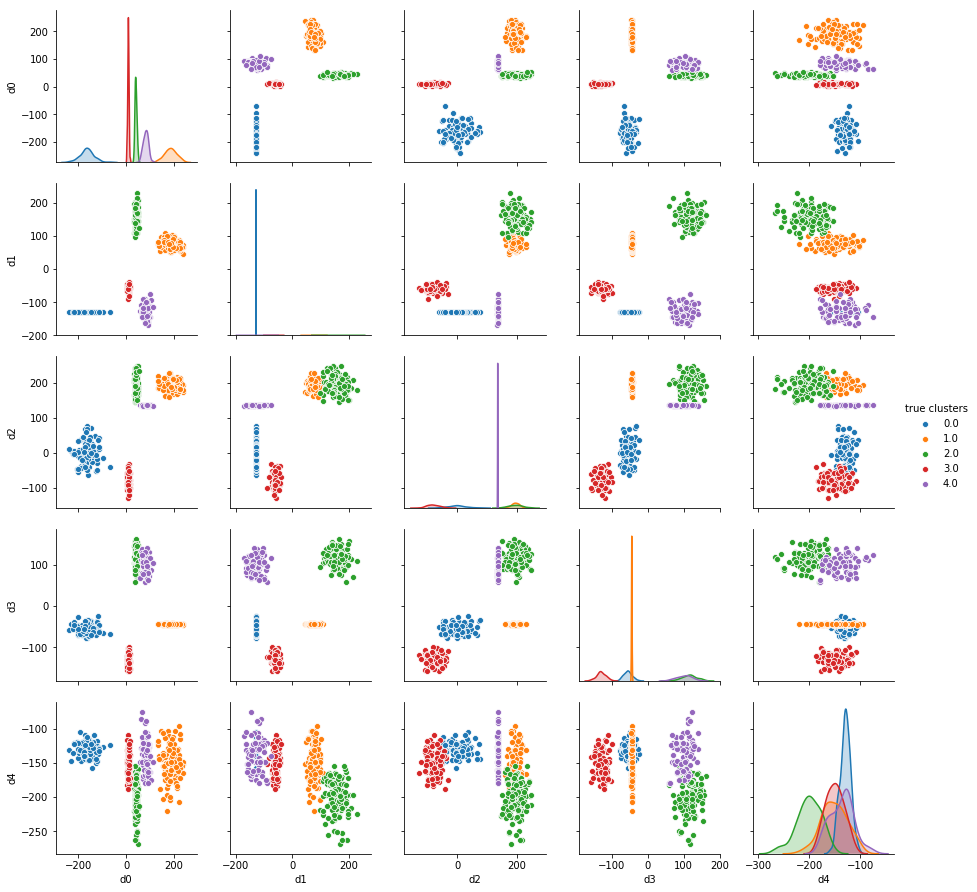

In [5]:
columns = ["d" + str(i) for i in range(data.shape[1])] + ['true clusters']
df = pd.DataFrame(np.hstack((data,np.reshape([clusters_true],(data.shape[0],1)))), columns=columns)
sns.pairplot(df, kind="scatter", hue='true clusters', vars=columns[:-1])

# f1 = data[:, 0]
# f2 = data[:, 1]
# X = np.array(list(zip(f1, f2)))
# plt.plot(f1, f2, 'ro')

## The agent

In [6]:
def distance(p, q, ord=2):
    return(np.linalg.norm(p-q, ord))

class ContrastAgent(object):
    def __init__(self, rigged_shuffle=False, verbose=False):
        self.clusters = np.array([]) # clusters[i] == j means that point i belongs to cluster j
        self.cluster_sizes = []
        self.data = np.array([[]])
        self.first_time = True # is True if nb
        self.nb_clusters = 0
        self.nb_seen = 0
        self.sensitiveness_find_cluster = 1.5 # if a point is alone with a radius of sensitiveness_find_cluster * stdist, create a new cluster
        self.sensitiveness_inf_dims = 5 # sensitiveness to determine if a dimension is too variable to be relevant for the cluster
        self.sensitiveness_zero_dims = 0.1 # sensitiveness to determine if a dimension is too concentrated to be relevant for the cluster
        self.stdist = 0
        self.stdists_per_cluster=[]
        self.verbose = verbose

    def clusterize_online(self):
        assert len(self.data), "empty data"
        if self.nb_clusters == 0:
            self.new_cluster(0)
            self.one_more_seen()
        for i, p in enumerate(self.data[self.nb_seen:], start=self.nb_seen):
            self.find_cluster(i, p, i)
            self.one_more_seen()

    def get_cluster_points(self, i):
        return data[np.argwhere(self.clusters == i)]

    def get_cluster_dimensions(self, i):
        """ return (relevant_dims, inf_dims, zero_dims) """
        stdist_i = self.stdists_per_cluster[i]
        cluster_points = self.get_cluster_points(i)
        relevant_dims, inf_dims, zero_dims = [], [], []
        for j in range(cluster_points.shape[1]):
            stdev = np.std(cluster_points[:,j])
            if stdev > self.sensitiveness_inf_dims * stdist_i:
                inf_dims.append(j)
            elif stdev < self.sensitiveness_zero_dims * stdist_i:
                zero_dims.append(j)
            else:
                relevant_dims.append(j)
        return relevant_dims, inf_dims, zero_dims
        
    def feed_data(self, d, shuffle=False):
        """Adds data to the agent's memory"""
        data = np.copy(d)
        if shuffle:
            np.random.shuffle(data)
        if self.nb_clusters == 0:
            self.data = np.copy(data)
            self.clusters = np.zeros(len(data))
            self.clusters.fill(-1)
        else:
            new_data = np.vstack((self.data, np.copy(data)))
            self.data = new_data
            new_clusters = np.zeros(len(data))
            new_clusters.fill(-1)
            new_clusters_all = np.hstack((self.clusters, new_clusters))
            self.clusters = new_clusters_all

    def find_cluster(self, i, p, until=None, recollection=False):
        distances = np.array([distance(p,q) for q in self.data[:until] if not np.all(p == q)])
        dist_min = np.min(distances)
        if not recollection:
            self.update_stdist(self.nb_seen, dist_min)
        closest = np.argmin(distances)
        if dist_min > self.sensitiveness_find_cluster * self.stdist:
#                 if self.verbose:
#                     print("new cluster
            if self.clusters[i] == -1 or not self.cluster_sizes[int(self.clusters[i])] == 1:
                # if p not already seen or is not already alone
                self.new_cluster(i)
        else:
#                 if self.verbose:
#                     print("-> cluster of {}".format(closest))
            self.clusters[i] = self.clusters[closest]
            self.update_stdists_per_cluster(int(self.clusters[i]), p)
            self.cluster_sizes[int(self.clusters[i])] += 1
            
    def new_cluster(self, p_index):
        self.clusters[p_index] = self.nb_clusters
        self.nb_clusters += 1
        self.cluster_sizes.append(1)
        self.stdists_per_cluster.append(0)

    def one_more_seen(self):
        self.nb_seen += 1

#     def print_clusters_old(self, only=-1):
#         self.colors = cm.rainbow(np.linspace(0, 1, self.nb_clusters))
#         for k in range(self.nb_clusters):
#             if only < 0 or k == only:
#                 points = np.array([self.data[i] for i in range(len(self.data)) if self.clusters[i] == k])
#                 plt.plot(points[:,0], points[:,1], 'o', color=self.colors[k])
                
    def print_clusters(self):
        columns = ["d" + str(i) for i in range(self.data.shape[1])] + ['cluster']
        df_1 = pd.DataFrame(np.hstack((self.data,np.reshape([self.clusters],(self.data.shape[0],1)))),  columns=columns)
        sns.pairplot(df_1, kind="scatter", hue="cluster", vars=columns[:-1])
                
    def shuffle(self, data_to_shuffle):
        np.random.shuffle(data_to_shuffle)

    def update_clusters(self, until_update=None, until_dist=None):
        for i, p in enumerate(self.data[:until_update]):
            self.find_cluster(i, p, until_dist, recollection = False)
        
    def update_stdist(self, nb_seen, distance):
        self.stdist = (max(1,nb_seen) * self.stdist + distance) / (nb_seen + 1)

    def update_stdists_per_cluster(self, i, p):
        old_dist = self.stdists_per_cluster[i]
        relevant_dims, inf_dims, zero_dims = self.get_cluster_dimensions(i)
        if len(relevant_dims):
            cluster_points_rd = self.get_cluster_points(i)[:,relevant_dims]
            p_rd = p[relevant_dims]
        elif len(inf_dims):
            cluster_points_rd = self.get_cluster_points(i)[:,inf_dims]
            p_rd = p[inf_dims]
        else:
            cluster_points_rd = self.get_cluster_points(i)[:,zero_dims]
            p_rd = p[zero_dims]
        array_dists = np.array([distance(p,q) for q in cluster_points_rd if not np.all(p == q)])
#         print(relevant_dims, inf_dims, zero_dims)
#         print(array_dists)
        dist_p = np.min(array_dists)
        csize = cluster_points_rd.shape[0]
        self.stdists_per_cluster[i] = (old_dist * csize + dist_p) / (csize + 1)

Final stdist: 21.874071164491717
All points in a cluster? True


/home/ashikaga/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ashikaga/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


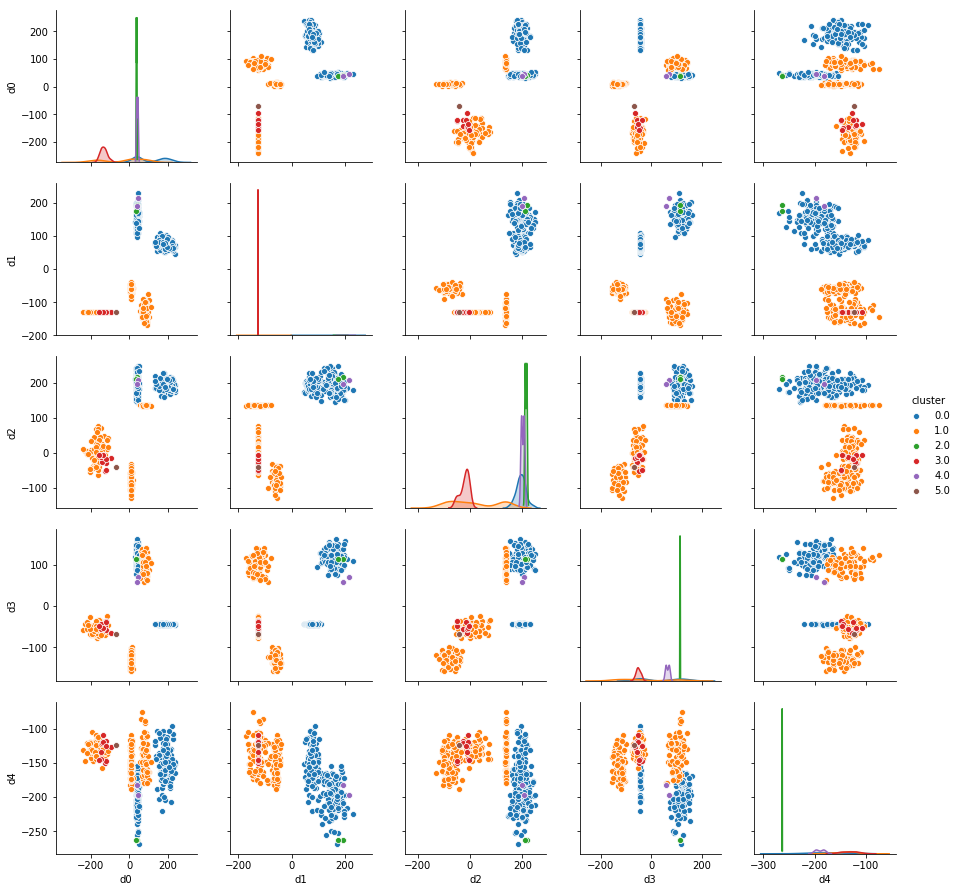

In [7]:
ca = ContrastAgent()
for i in range(len(data)):
    ca.feed_data(data[[i]], shuffle=False)
    ca.clusterize_online()
print("Final stdist: {}".format(ca.stdist))
print("All points in a cluster? {}".format(-1 not in ca.clusters))
ca.print_clusters()

In [16]:
# ca.update_clusters()
# ca.print_clusters()

In [8]:
ca.stdists_per_cluster

[22.026339336865483,
 19.924030288492148,
 6.382685097981672,
 17.19208606907762,
 10.872395163816277,
 0]

In [54]:
ca.cluster_sizes

[231, 253, 2, 11, 2, 1]